In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
# from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
import pingouin as pg
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [10]:
results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_keep_units_consistent_0/"

In [2]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [18]:
# session_table.columns

In [11]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = False

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [12]:
# session-wise average decoding accuracy
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#add total n units, cross-modal dprime, n good blocks?

new_results_session_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
    )
    #get total n units
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    #join on session table to get cross-modal dprime, etc.
    .join(
        other=session_table.filter(
            pl.col('session_id').is_in(dr_session_list)
        ).select(
            'session_id',
            'n_passing_blocks',
            'cross_modality_dprime_vis_blocks',
            'cross_modality_dprime_aud_blocks',
        ).lazy(),
        on='session_id',
        how='left',
    )
    # get the means for each recording over repeats:
    .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                               'cross_modality_dprime_aud_blocks', 'total_n_units', 'is_sole_recording'}, maintain_order=True)
    .agg(
        pl.col('balanced_accuracy_test').mean(), # over repeats
    )
    # get the aligned result and median over shifts:
    # .group_by(grouping_cols - {'electrode_group_names'} | {'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
    #                                                        'cross_modality_dprime_aud_blocks', 'total_n_units'})
    .group_by(grouping_cols| {'n_passing_blocks', 'cross_modality_dprime_vis_blocks',
                              'cross_modality_dprime_aud_blocks', 'total_n_units', 'is_sole_recording'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
        pl.col('balanced_accuracy_test', 'shift_idx').sort_by('shift_idx'),
    )
    # get the difference between true and null:
    .with_columns(
        pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
        #assumes each row is one probe
        pl.col('electrode_group_names').list.first().alias('electrode_group_names'),
    )
    .sort('session_id', 'structure', 'bin_center', 'electrode_group_names', 'unit_subsample_size', descending=False)
    .collect()
)


In [13]:
new_results_session_df

session_id,unit_subsample_size,time_aligned_to,electrode_group_names,is_sole_recording,total_n_units,cross_modality_dprime_vis_blocks,n_passing_blocks,bin_center,structure,cross_modality_dprime_aud_blocks,bin_size,mean_true,median_null,balanced_accuracy_test,shift_idx,mean_diff
str,u16,enum,str,bool,u32,str,i64,f64,str,str,f64,f64,f64,list[f64],list[i16],f64
"""626791_2022-08-15""",20,"""stim_start_time""","""probeC""",true,67,"""3.0732675211951777;1.491975985…",5,-1.25,"""AUDp""","""1.438862250154771;0.1260493487…",0.5,0.683742,0.6381,"[0.578339, 0.577407, … 0.592953]","[-44, -43, … 37]",0.045642
"""626791_2022-08-15""",20,"""stim_start_time""","""probeC""",true,67,"""3.0732675211951777;1.491975985…",5,-0.75,"""AUDp""","""1.438862250154771;0.1260493487…",0.5,0.676873,0.616516,"[0.566918, 0.568284, … 0.566496]","[-44, -43, … 37]",0.060358
"""626791_2022-08-15""",20,"""stim_start_time""","""probeC""",true,67,"""3.0732675211951777;1.491975985…",5,-0.25,"""AUDp""","""1.438862250154771;0.1260493487…",0.5,0.673035,0.607159,"[0.554119, 0.566995, … 0.561141]","[-44, -43, … 37]",0.065875
"""626791_2022-08-15""",20,"""stim_start_time""","""probeC""",true,67,"""3.0732675211951777;1.491975985…",5,0.25,"""AUDp""","""1.438862250154771;0.1260493487…",0.5,0.665332,0.588383,"[0.561355, 0.56813, … 0.565382]","[-44, -43, … 37]",0.076949
"""626791_2022-08-15""",20,"""stim_start_time""","""probeC""",true,67,"""3.0732675211951777;1.491975985…",5,0.75,"""AUDp""","""1.438862250154771;0.1260493487…",0.5,0.668968,0.613054,"[0.599712, 0.601363, … 0.562407]","[-44, -43, … 37]",0.055914
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""761583_2024-12-17""",20,"""stim_start_time""","""probeC""",true,222,"""2.2932255512267474;2.536260776…",5,3.25,"""VPM""","""1.9877370982559819;2.147703800…",0.5,0.517473,0.511535,"[0.502503, 0.493203, … 0.520453]","[-45, -44, … 25]",0.005938
"""761583_2024-12-17""",20,"""stim_start_time""","""probeC""",true,222,"""2.2932255512267474;2.536260776…",5,3.75,"""VPM""","""1.9877370982559819;2.147703800…",0.5,0.522831,0.516185,"[0.508239, 0.510186, … 0.527407]","[-45, -44, … 25]",0.006646
"""761583_2024-12-17""",20,"""stim_start_time""","""probeC""",true,222,"""2.2932255512267474;2.536260776…",5,4.25,"""VPM""","""1.9877370982559819;2.147703800…",0.5,0.511531,0.515621,"[0.514576, 0.513974, … 0.51327]","[-45, -44, … 25]",-0.00409


In [ ]:
new_results_session_df.write_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\session_wise_results_w_performance_probes.parquet")

In [15]:
new_results_session_pd = new_results_session_df.to_pandas().query('bin_center==-0.25')

In [ ]:
# loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\decoder_accuracy_by_session.parquet"
# new_results_session_pd = pd.read_parquet(loadpath).query('bin_center==-0.25')

In [16]:
new_results_session_pd['electrode_group_names'].unique()

array(['probeC', 'probeB', 'probeF', 'probeA', 'probeD', 'probeE'],
      dtype=object)

In [17]:
# new_results_session_pd
# all_units_table_path='s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/units.parquet'
all_units_table_path=r"D:\units_v0.272.parquet"
all_units_table=pd.read_parquet(all_units_table_path)


In [18]:
all_units_table.query('(structure=="SNr") and session_id in @dr_session_list and activity_drift<=0.2 and \
                      isi_violations_ratio<=0.5 and presence_ratio>=0.7 and amplitude_cutoff<=0.1')['session_id'].value_counts()

session_id
703880_2024-04-15    35
649943_2023-02-15    16
708016_2024-04-29    15
737403_2024-09-26    15
686176_2023-12-07    12
733891_2024-09-19    12
733891_2024-09-17    10
733891_2024-09-18    10
714748_2024-06-26     9
649943_2023-02-16     8
750329_2024-11-27     8
733891_2024-09-16     7
660023_2023-08-09     3
741148_2024-10-18     2
743199_2024-12-04     2
737403_2024-09-24     1
Name: count, dtype: int64

In [19]:
#get mean ccf for each session-structure AND probe

session_structure_ccf_coords={
    'session_id':[],
    'structure':[],
    'probe':[],
    'ccf_dv':[],
    'ccf_ml':[],
    'ccf_ap':[]
}

for session_id in new_results_session_pd['session_id'].unique():
    session_pd=new_results_session_pd.query('session_id==@session_id')
    for structure in session_pd['structure'].unique():
        for probe in session_pd.query('structure==@structure')['electrode_group_names'].unique():
            
            if structure=='SCs':
                structure_query='(structure=="SCop" | structure=="SCsg" | structure=="SCzo")'
            elif structure=='SCm':
                structure_query='(structure=="SCig" | structure=="SCiw" | structure=="SCdg" | structure=="SCdw")'
            else:
                structure_query='structure==@structure'

            session_structure_units=all_units_table.query(f'session_id==@session_id & {structure_query} & electrode_group_name==@probe')
            ccf_dv=np.nanmean(session_structure_units['ccf_dv'].values)
            ccf_ml=np.nanmean(session_structure_units['ccf_ml'].values)
            ccf_ap=np.nanmean(session_structure_units['ccf_ap'].values)

            session_structure_ccf_coords['session_id'].append(session_id)
            session_structure_ccf_coords['structure'].append(structure)
            session_structure_ccf_coords['probe'].append(probe)
            session_structure_ccf_coords['ccf_dv'].append(ccf_dv)
            session_structure_ccf_coords['ccf_ml'].append(ccf_ml)
            session_structure_ccf_coords['ccf_ap'].append(ccf_ap)

session_structure_ccf_coords_df=pd.DataFrame(session_structure_ccf_coords)


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_23820\3100135760.py:25: RuntimeWarning: Mean of empty slice
  ccf_dv=np.nanmean(session_structure_units['ccf_dv'].values)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_23820\3100135760.py:26: RuntimeWarning: Mean of empty slice
  ccf_ml=np.nanmean(session_structure_units['ccf_ml'].values)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_23820\3100135760.py:27: RuntimeWarning: Mean of empty slice
  ccf_ap=np.nanmean(session_structure_units['ccf_ap'].values)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_23820\3100135760.py:25: RuntimeWarning: Mean of empty slice
  ccf_dv=np.nanmean(session_structure_units['ccf_dv'].values)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_23820\3100135760.py:26: RuntimeWarning: Mean of empty slice
  ccf_ml=np.nanmean(session_structure_units['ccf_ml'].values)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_23820\3100135760.py:27: RuntimeWarning: Mean of empty slice
  ccf_ap=np.nanmea

In [20]:
new_results_session_w_ccf_pd=(
    new_results_session_pd
    .merge(
        session_structure_ccf_coords_df,
        left_on=['session_id', 'structure', 'electrode_group_names'],
        right_on=['session_id', 'structure', 'probe'],
        how='left',
    )
)

In [21]:
new_results_session_w_ccf_pd.columns

Index(['session_id', 'unit_subsample_size', 'time_aligned_to',
       'electrode_group_names', 'is_sole_recording', 'total_n_units',
       'cross_modality_dprime_vis_blocks', 'n_passing_blocks', 'bin_center',
       'structure', 'cross_modality_dprime_aud_blocks', 'bin_size',
       'mean_true', 'median_null', 'balanced_accuracy_test', 'shift_idx',
       'mean_diff', 'probe', 'ccf_dv', 'ccf_ml', 'ccf_ap'],
      dtype='object')

In [22]:
new_results_session_w_ccf_pd.to_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\session_wise_results_w_ccf_coords.parquet")

Pearson r=0.087, p=0.386


(0.5, 1.0)

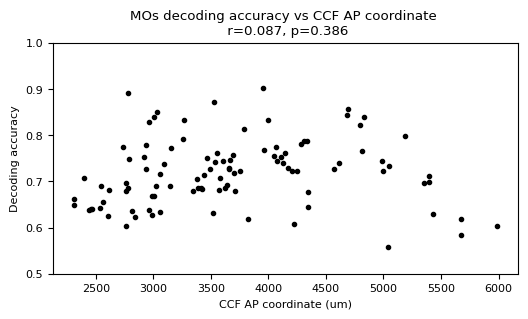

In [23]:
sel_structure='MOs'

decoding_accuracy=new_results_session_w_ccf_pd.query('structure==@sel_structure and session_id in @dr_session_list')['mean_true'].values
ap_coords=new_results_session_w_ccf_pd.query('structure==@sel_structure and session_id in @dr_session_list')['ccf_ap'].values
ml_coords=new_results_session_w_ccf_pd.query('structure==@sel_structure and session_id in @dr_session_list')['ccf_ml'].values

#AP
r,p=stats.pearsonr(ap_coords, decoding_accuracy)
print(f'Pearson r={r:.3f}, p={p:.3f}')

fig,ax=plt.subplots(figsize=(6,3))
ax.plot(ap_coords, decoding_accuracy, 'k.')
ax.set_xlabel('CCF AP coordinate (um)')
ax.set_ylabel('Decoding accuracy')
ax.set_title(f'{sel_structure} decoding accuracy vs CCF AP coordinate \n r={r:.3f}, p={p:.3f}')
ax.set_ylim(0.5,1)

In [ ]:
# #save as editable pdf
# savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-01-predict_proba_corr_updates\MOs_decoding_accuracy_vs_CCF_AP.pdf'
# fig.savefig(savepath, bbox_inches='tight', dpi=300,
#             transparent=True, format='pdf', pad_inches=0.1)

Pearson r=0.184, p=0.066


(0.5, 1.0)

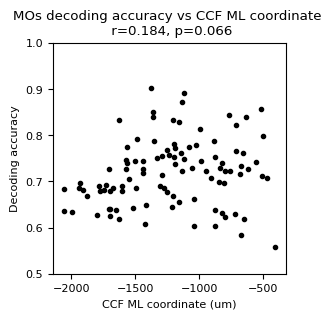

In [24]:
#ML 
r,p=stats.pearsonr(ml_coords, decoding_accuracy)
print(f'Pearson r={r:.3f}, p={p:.3f}')
fig,ax=plt.subplots(figsize=(3,3))
ax.plot(ml_coords-5700, decoding_accuracy, 'k.')
ax.set_xlabel('CCF ML coordinate (um)')
ax.set_ylabel('Decoding accuracy')
ax.set_title(f'{sel_structure} decoding accuracy vs CCF ML coordinate \n r={r:.3f}, p={p:.3f}')
ax.set_ylim(0.5,1)

In [ ]:
# #save as editable pdf
# savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-01-predict_proba_corr_updates\MOs_decoding_accuracy_vs_CCF_ML.pdf'
# fig.savefig(savepath, bbox_inches='tight', dpi=300,
#             transparent=True, format='pdf', pad_inches=0.1)

Text(0.5, 0, 'CCF ML coordinate (um)')

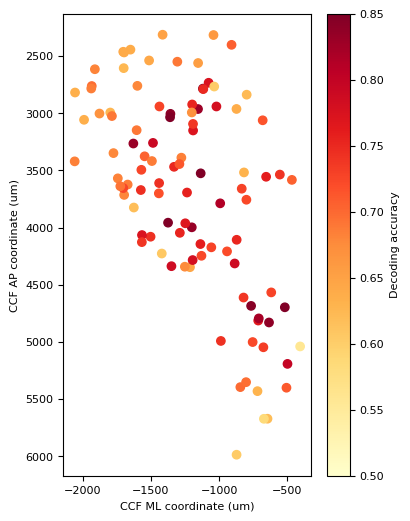

In [25]:
fig,ax=plt.subplots(figsize=(4,6))
ax.scatter(ml_coords-5700, ap_coords, c=decoding_accuracy, vmin=0.5, vmax=0.85, cmap='YlOrRd')
ax.invert_yaxis()
colorbar = plt.colorbar(ax.collections[0], ax=ax)
colorbar.set_label('Decoding accuracy')
ax.set_ylabel('CCF AP coordinate (um)')
ax.set_xlabel('CCF ML coordinate (um)')

In [93]:
#save as editable pdf
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-01-predict_proba_corr_updates\MOs_decoding_accuracy_vs_CCF_AP_ML_diff_colors.pdf'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='pdf', pad_inches=0.1)

In [114]:
# #boxplot of decoding accuracy for MOs, plus individual points for each experiment
# fig,ax=plt.subplots(figsize=(1.5,6))
# ax.boxplot(new_results_session_w_ccf_pd.query('structure==@sel_structure and session_id in @dr_session_list')['mean_true'].values, 
#            positions=[1], widths=0.5, showfliers=False, medianprops={'color':'k'})
# #generate random x values around 1 for scatter
# x_jitter=np.random.normal(0,0.1,size=len(decoding_accuracy))
# ax.plot(np.ones_like(decoding_accuracy)+x_jitter, decoding_accuracy, 'k.', alpha=0.2, markersize=8)

# ax.set_ylim(0.5,1)


(0.5, 1.0)

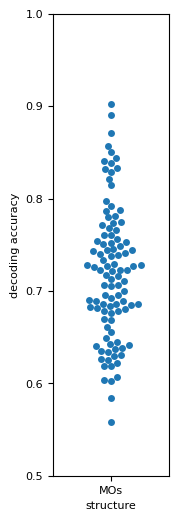

In [26]:
import seaborn as sns

fig,ax=plt.subplots(figsize=(1.5,6))

sns.swarmplot(data=new_results_session_w_ccf_pd.query('structure==@sel_structure and session_id in @dr_session_list'), 
            x="structure", y="mean_true", ax=ax)

ax.set_ylabel('decoding accuracy')
ax.set_ylim(0.5,1)

# fig=sns.catplot(data=new_results_session_w_ccf_pd.query('structure==@sel_structure and session_id in @dr_session_list'), 
#             x="structure", y="mean_true", kind="swarm")

#change figure props

In [27]:
new_results_session_w_ccf_pd.query('structure==@sel_structure and session_id in @dr_session_list')['session_id'].unique().shape

(63,)

In [116]:
#save as editable pdf
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-01-predict_proba_corr_updates\MOs_decoding_accuracy_swarm_plot.pdf'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='pdf', pad_inches=0.1)

In [140]:
# new_results_session_w_ccf_pd.query('structure==@sel_structure and session_id in @dr_session_list')

mouseid=[]
for rr,row in new_results_session_w_ccf_pd.iterrows():
    mouseid.append(row.session_id.split('_')[0])

new_results_session_w_ccf_pd['mouseid']=mouseid

In [142]:
new_results_session_w_ccf_pd.query('structure==@sel_structure and session_id in @dr_session_list')['mouseid'].unique().shape

(31,)